# Perplexity ratio score exploratory data analysis

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

import configuration as config
import functions.data_manipulation as data_funcs
import functions.plotting as plot_funcs

/mnt/arkk/llm_detector_benchmarking/benchmarking


## 1. Hans et al. (2024) Datasets
First, let's parse and collect the data from the original Hans et al. (2024) Binoculars publication. Get some metadata about text length and composition and get the data from all six datasets into one dataframe for easy handling.

In [2]:
# Dict describing datasets to load
hans_datasets = {
    'falcon7': {
        'cc_news': 'cc_news/cc_news-falcon7.jsonl',
        'cnn': 'cnn/cnn-falcon7.jsonl',
        'pubmed': 'pubmed/pubmed-falcon7.jsonl'
    },
    'llama2-13b': {
        'cc_news': 'cc_news/cc_news-llama2_13.jsonl',
        'cnn': 'cnn/cnn-llama2_13.jsonl',
        'pubmed': 'pubmed/pubmed-llama2_13.jsonl' 
    }
}

# Output dict for collected & combined datasets
hans_data = {
    'Generation model': [],
    'Data source': [],
    'Human text length (words)': [],
    'Human text': [],
    'Synthetic text': [],
    'Synthetic text length (words)': [],
    'Human text fraction': []
}

# Output dict for datasets wide metadata
hans_metadata = {
    'Generation model': [],
    'Data source': [],
    'Records': [],
    'Mean human text length (words)': [],
    'Human text length STD': [],
    'Mean synthetic text length (words)': [],
    'Synthetic text length STD': [],
    'Mean human text fraction': []
}

# Parse, collect and combine data and get metadata
hans_metadata_df, hans_data_df = data_funcs.parse_hans_data(
    hans_datasets = hans_datasets, 
    hans_data = hans_data, 
    hans_metadata = hans_metadata,
    binoculars_data_path = config.HANS_DATA_PATH
)

# Save as JSON for later use
output_file = f'{config.HANS_DATA_PATH}/aggregated_hans_data.jsonl'

with open(output_file, 'w') as file:
    file.write(hans_data_df.to_json(lines=True, orient='records'))

Parsed falcon7, cc_news data: 1169 records
Parsed falcon7, cnn data: 876 records
Parsed falcon7, pubmed data: 112 records
Parsed llama2-13b, cc_news data: 4714 records
Parsed llama2-13b, cnn data: 2208 records
Parsed llama2-13b, pubmed data: 2198 records


Next, let's get TF-IDF across the datasets so we have some idea of the relative complexity.

In [3]:
human_tfidf_df, synthetic_tfidf_df = data_funcs.tf_idf(data_df = hans_data_df)
human_tfidf_df.head()

,00,000,0000,00000,000000,0000000172,000001,000004496,000006,0000068,...,黃之鋒,ﬁnding,ﬁne,ﬁnely,ﬁrst,ﬂaked,ﬂour,ﬂoured,ﬂuffy,𝐤𝖔𝖇𝐲
0,0.048244,0.042917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.031481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
human_tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Columns: 175741 entries, 00 to 𝐤𝖔𝖇𝐲
dtypes: float64(175741)
memory usage: 14.8 GB


### 1.1. Hans datasets structure
Take a look at what we have:

In [5]:
# Metadata
hans_metadata_df.head(7)

,Generation model,Data source,Records,Mean human text length (words),Human text length STD,Mean synthetic text length (words),Synthetic text length STD,Mean human text fraction
0,falcon7,cc_news,1169,935.790240,775.046347,369.841610,39.872910,0.687366
1,falcon7,cnn,876,967.403429,295.668681,383.460571,26.776287,0.704008
2,falcon7,pubmed,112,2933.936937,1884.328293,336.387387,59.922703,0.861709
3,llama2-13b,cc_news,4714,863.986845,716.515544,330.481434,39.772044,0.692970
4,llama2-13b,cnn,2208,893.908473,296.323984,570.213412,133.191800,0.602143
5,llama2-13b,pubmed,2198,3257.725080,2587.036147,579.649522,130.517106,0.800563


In [6]:
# Total amounts of text
print(f"Total human text: {sum(hans_data['Human text length (words)'])} words")
print(f"Total synthetic text: {sum(hans_data['Synthetic text length (words)'])} words")
print(f"Data is {round(mean(hans_metadata_df['Mean human text fraction']) * 100, 1)}% human by words")

Total human text: 15467196 words
Total synthetic text: 4894352 words
Data is 72.5% human by words


In [7]:
print(f"Human example: {' '.join(hans_data['Human text'][0].split(' ')[:100])}")
print()
print(f"Synthetic example: {' '.join(hans_data['Synthetic text'][0].split(' ')[:100])}")

Human example: H. B. Fuller Company (NYSE:FUL) VP Traci L. Jensen sold 5,397 shares of the firm’s stock in a transaction dated Monday, October 2nd. The stock was sold at an average price of $58.40, for a total transaction of $315,184.80. The transaction was disclosed in a legal filing with the Securities & Exchange Commission, which is available through this link.
Shares of H. B. Fuller Company (NYSE:FUL) opened at 56.81 on Friday. The company’s 50-day moving average is $53.88 and its 200 day moving average is $52.11. The firm has a market capitalization of $2.87 billion, a PE ratio of 25.96 and

Synthetic example:  $54.40, for a total value of $298,532.80. Following the completion of the sale, the vice president now owns 11,041 shares of the company’s stock, valued at $594,803.40. The sale was disclosed in a document filed with the Securities & Exchange Commission, which is accessible through this link.
H. B. Fuller Company (NYSE:FUL) traded down 1.30% during midday trading on Monday,

In [8]:
# Combined dataset structure information
hans_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Generation model               11271 non-null  object 
 1   Data source                    11271 non-null  object 
 2   Human text length (words)      11271 non-null  int64  
 3   Human text                     11271 non-null  object 
 4   Synthetic text                 11271 non-null  object 
 5   Synthetic text length (words)  11271 non-null  int64  
 6   Human text fraction            11271 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 616.5+ KB


In [9]:
# Combined dataset statistics
hans_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Human text length (words),11271.0,1372.300240,1594.344645,143.000000,646.000000,848.000000,1320.50000,50234.000000
Synthetic text length (words),11271.0,434.242924,143.796153,1.000000,336.000000,374.000000,539.00000,1473.000000
Human text fraction,11271.0,0.698096,0.105767,0.377897,0.628042,0.685624,0.76408,0.996644


In [10]:
# Combined dataset sample
hans_data_df.head()

,Generation model,Data source,Human text length (words),Human text,Synthetic text,Synthetic text length (words),Human text fraction
0,falcon7,cc_news,836,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,"$54.40, for a total value of $298,532.80. Fol...",307,0.731409
1,falcon7,cc_news,1153,"On Aug. 21, a solar eclipse will cut across th...",covers the sun.\nThe total eclipse will be vi...,382,0.751140
2,falcon7,cc_news,725,Study on Aerosol Valves Market by Infinium Glo...,of Aerosol Valves market by type (Aerosol Noz...,324,0.691134
3,falcon7,cc_news,689,"VICTORIA – More than 1,400 British Columbians ...",",423 illicit drug overdose deaths in 2017, up ...",373,0.648776
4,falcon7,cc_news,869,"On land, heatwaves can be deadly for humans an...","sometimes even larger, more mobile species of...",386,0.692430


### 1.2. Hans datasets plots
#### 1.2.1. Text length distributions

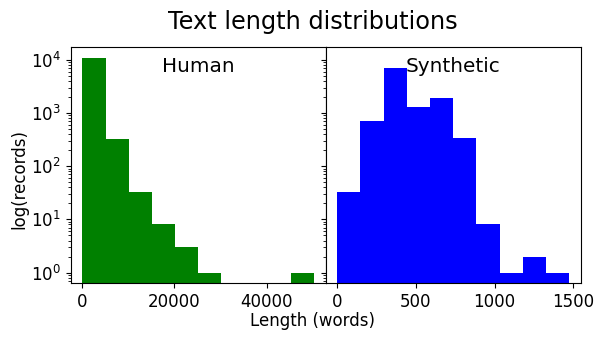

In [11]:
# Set general font size
plt.rcParams['font.size'] = 12

# Set-up figure and axis array
fig, axs = plt.subplots(1, 2, figsize = (6, 3), sharey = 'row', tight_layout = True, gridspec_kw = {'wspace':0, 'hspace':0})

# Draw the histograms
axs[0].hist(hans_data_df['Human text length (words)'], facecolor = 'green', log = True, label = 'Human text')
axs[1].hist(hans_data_df['Synthetic text length (words)'], facecolor = 'blue', log = True, label = 'synthetic text')

# Annotate figure
fig.text(0.5, 1, 'Text length distributions', ha = 'center', fontsize = 'x-large')
fig.text(0.5, 0.01, 'Length (words)', ha = 'center')
fig.text(0.01, 0.5, 'log(records)', va = 'center', ha = 'center', rotation = 90)
axs[0].set_title('Human', y = 1.0, pad = -18)
axs[1].set_title('Synthetic', y = 1.0, pad = -18)

plt.show()

#### 1.2.2. Human-synthetic text length correlation by record

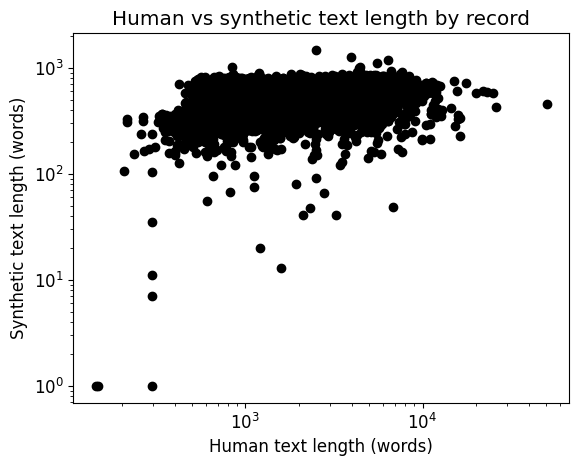

In [12]:
plt.title('Human vs synthetic text length by record')
plt.scatter(hans_data_df['Human text length (words)'], hans_data_df['Synthetic text length (words)'], color = 'black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Human text length (words)')
plt.ylabel('Synthetic text length (words)')
plt.show()

#### 1.2.3. Text composition distribution over records

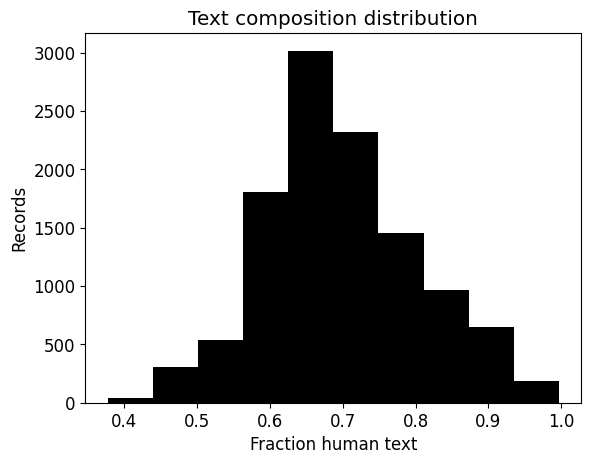

In [13]:
plt.title('Text composition distribution')
plt.hist(hans_data_df['Human text fraction'], facecolor = 'black')
plt.xlabel('Fraction human text')
plt.ylabel('Records')
plt.show()

#### 1.2.4. TF-IDF distributions

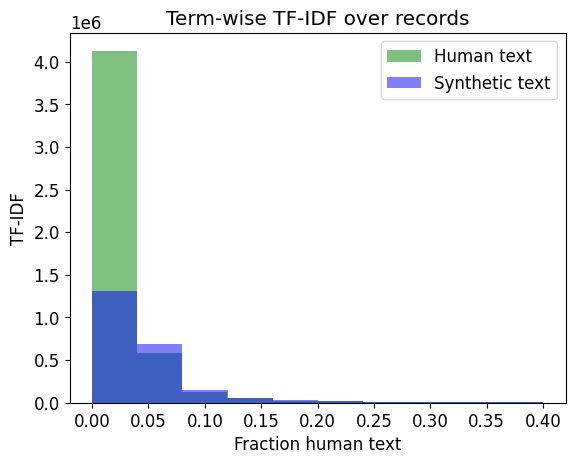

In [14]:
human_tfidfs = human_tfidf_df.to_numpy().flatten()
synthetic_tfidfs = synthetic_tfidf_df.to_numpy().flatten()

plt.title('Term-wise TF-IDF over records')
plt.hist(human_tfidfs[(human_tfidfs != 0.0) & (human_tfidfs < 0.4)], facecolor = 'green', label = 'Human text', alpha = 0.5)
plt.hist(synthetic_tfidfs[(synthetic_tfidfs != 0.0) & (synthetic_tfidfs < 0.4)], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
plt.xlabel('Fraction human text')
plt.ylabel('TF-IDF')
plt.legend(loc = 'upper right')
plt.show()

## 2. Perplexity ratio scores

### 2.1. Model benchmark

In [15]:
# Load the data
data_df = pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/perplexity_ratio_model_benchmark.jsonl', lines=True, orient='records')

# Translation dict for column names
column_renaming_dict = {
    'hf_model_string': 'Scoring model',
    'perplexity_ratio_score': 'Perplexity ratio score',
    'perplexity': 'Perplexity',
    'cross-perplexity': 'Cross-perplexity',
    'length_words': 'Input length (words)',
    'length_tokens': 'Input length (tokens)',
    'data_source': 'Data source',
    'generating_model': 'Generation model',
    'reader_model': 'Reader model',
    'writer_model': 'Writer model',
    'reader_device': 'Reader device',
    'writer_device': 'Writer device',
    'author': 'Author',
    'device_map': 'Device',
    'iteration': 'Iteration',
    'text': 'Text'
}

# Translation dict for string values
value_renaming_dict = {
    'cuda:1': 'NVIDIA K80',
    'cuda:2': 'NVIDIA k80',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B',
    'google/gemma-2-9b': 'Gemma2-9B',
    'meta-llama/Meta-Llama-3-8B-instruct': 'LLaMA3-8B instruct',
    'tiiuae/falcon-7b-instruct': 'Falcon-7B instruct',
    'mistralai/Mistral-7B-Instruct-v0.3': 'Mistral-7B instruct',
    'meta-llama/Llama-2-7b-chat-hf': 'LLaMA2-7b chat',
    'google/gemma-2-9b-it': 'Gemma2-9B instruct'
}

# Translate column names and string values for pretty printing in plots
data_df = plot_funcs.replace_strings(
    df = data_df,
    column_renaming_dict = column_renaming_dict,
    value_renaming_dict = value_renaming_dict
)

# Replace string NAN and OOM values with np.NAN
data_df = plot_funcs.clean_nan_oom(data_df)

# Drop np.NAN rows
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4547 entries, 0 to 5002
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Iteration               4547 non-null   float64
 1   Scoring model           4547 non-null   object 
 2   Device                  4547 non-null   object 
 3   Perplexity ratio score  4547 non-null   float64
 4   Perplexity              4547 non-null   float64
 5   Cross-perplexity        4547 non-null   float64
 6   Input length (words)    4547 non-null   float64
 7   Input length (tokens)   4547 non-null   float64
 8   Data source             4547 non-null   object 
 9   Generation model        4547 non-null   object 
 10  Reader model            4547 non-null   object 
 11  Writer model            4547 non-null   object 
 12  Reader device           4547 non-null   object 
 13  Writer device           4547 non-null   object 
 14  Author                  4547 non-null   objec

In [16]:
data_df.head(3)

,Iteration,Scoring model,Device,Perplexity ratio score,Perplexity,Cross-perplexity,Input length (words),Input length (tokens),Data source,Generation model,Reader model,Writer model,Reader device,Writer device,Author,Text
0,1.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.767108,1.551342,2.022326,138.0,364.0,cc_news,falcon7,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"vs Top 10: 1-3 (L-Bisping, L-Weidman, L-Weidma..."
1,2.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.773936,2.313174,2.988844,219.0,272.0,pubmed,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,synthetic,problem in people over 60 years old and one of...
2,3.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",1.055911,3.332735,3.156264,87.0,108.0,cnn,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"Ayatollah Sadegh Larijani, who heads Iran's ju..."


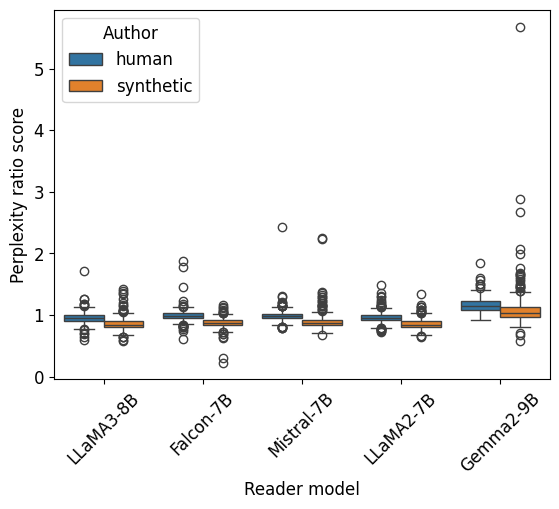

In [17]:
ax = sns.boxplot(data = data_df, x = 'Reader model', y = 'Perplexity ratio score', hue = 'Author')
ax.tick_params(axis = 'x', labelrotation = 45)
plt.show()

### 2.2. LLaMA3-8B

In [18]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/pubmed-scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.head()

,Fragment,Fragment length (tokens),Dataset,Source,String,Reader peak memory (GB),Writer peak memory (GB),Perplexity,Cross-perplexity,Perplexity ratio score
0,0,173,pubmed-falcon7,human,my introduction to research occurred in the su...,8.087868,7.801447,2.925811,3.168792,0.923320
1,1,175,pubmed-falcon7,human,"which revolutionized work on proteins , was ju...",8.110666,7.818082,2.931023,2.905956,1.008626
2,2,71,pubmed-falcon7,human,"structural protein , a hydrophobic miniprotei...",6.845889,6.790534,3.388054,3.455927,0.980360
3,3,108,pubmed-falcon7,human,- known model that still dominates our thinkin...,7.266596,7.122000,2.992673,3.299628,0.906973
4,4,357,pubmed-falcon7,human,ions and other polar substances .\nthe fluidit...,10.595652,10.002441,2.815971,2.958800,0.951727


In [19]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33628 entries, 0 to 34520
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment                  33628 non-null  int64  
 1   Fragment length (tokens)  33628 non-null  int64  
 2   Dataset                   33628 non-null  object 
 3   Source                    33628 non-null  object 
 4   String                    33628 non-null  object 
 5   Reader peak memory (GB)   33628 non-null  float64
 6   Writer peak memory (GB)   33628 non-null  float64
 7   Perplexity                33628 non-null  float64
 8   Cross-perplexity          33628 non-null  float64
 9   Perplexity ratio score    33628 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 2.8+ MB


In [20]:
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

## Perplexity vs cross-perplexity

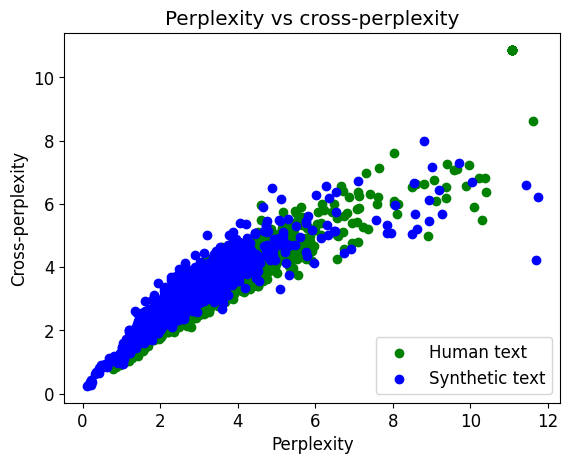

In [21]:
plt.title('Perplexity vs cross-perplexity')
plt.scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
plt.scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
plt.legend(loc = 'lower right')
plt.xlabel('Perplexity')
plt.ylabel('Cross-perplexity')
plt.show()

## Perplexity ratio score distribution

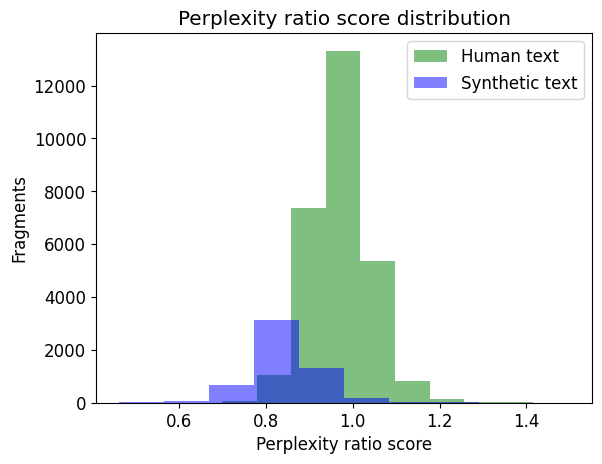

In [22]:
plt.title('Perplexity ratio score distribution')
plt.hist(human_fragments['Perplexity ratio score'][human_fragments['Perplexity ratio score'] < 1.5], facecolor = 'green', label = 'Human text', alpha = 0.5)
plt.hist(synthetic_fragments['Perplexity ratio score'][synthetic_fragments['Perplexity ratio score'] < 1.5], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Fragments')
plt.show()

## Binoculars score by fragment length

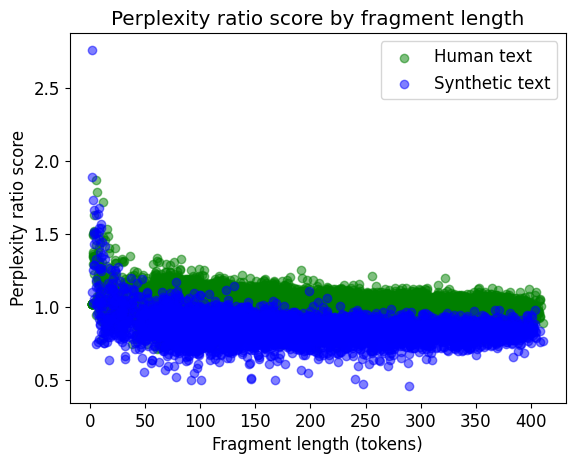

In [23]:
plt.title('Perplexity ratio score by fragment length')
plt.scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
plt.scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
plt.legend(loc = 'upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Perplexity ratio score')
plt.show()

## Fragment length distribution

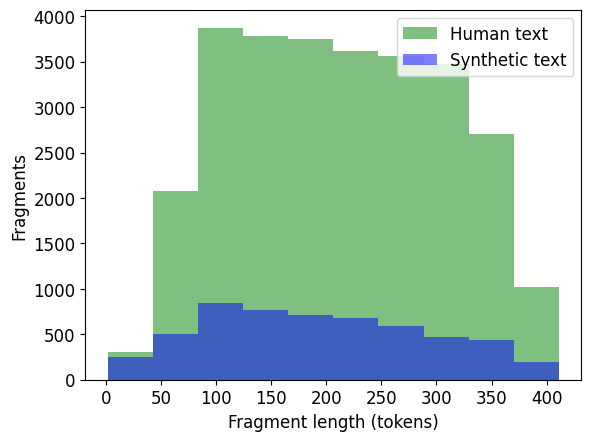

In [24]:
plt.hist(human_fragments['Fragment length (tokens)'], facecolor = 'green', label = 'Human text', alpha = 0.5)
plt.hist(synthetic_fragments['Fragment length (tokens)'], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Fragments')
plt.show()